In [14]:
import os
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import PIL

## Examine Image Sizes

In [3]:
image_dir = 'images/'
files = os.listdir(image_dir)
images = [f for f in files if re.search(r'.jpg$', f)]

sizes = []

for image in images:
    img = PIL.Image.open(f'{image_dir}/{image}')
    sizes.append(img.size)

In [4]:
sizes_df = pd.DataFrame({'img_size':sizes})
sizes_df.value_counts(ascending=False)

img_size   
(750, 1000)    6505
(1000, 750)     552
(562, 1000)     518
(450, 1000)     290
(753, 1000)     196
               ... 
(746, 690)        1
(625, 1000)       1
(619, 1000)       1
(612, 408)        1
(656, 468)        1
Length: 64, dtype: int64

## Get Training Dataset

Note, `dataset_generator.ipynb` creates correct directory structure

In [5]:
img_size = (256, 256)

dataset = keras.preprocessing.image_dataset_from_directory(
    'images_by_class/train/',
    batch_size=None, 
    image_size=img_size
)

Found 5559 files belonging to 6 classes.


2022-12-17 02:23:42.779441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:23:42.786696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:23:42.787342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:23:42.788317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Look at image data

In [6]:
for image, label in dataset.take(3):
    print(image.shape)  # (64, 200, 200, 3)
    print(image[0,0,])
    print(image.dtype)  # float32
    print(label.shape)  # (64,)
    print(label)
    print(label.dtype)  # int32

(256, 256, 3)
tf.Tensor([174.4339 169.4339 149.4339], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(0, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([54.562805 34.92218  15.469055], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(3, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([156.91376 159.91376 148.91376], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(3, shape=(), dtype=int32)
<dtype: 'int32'>


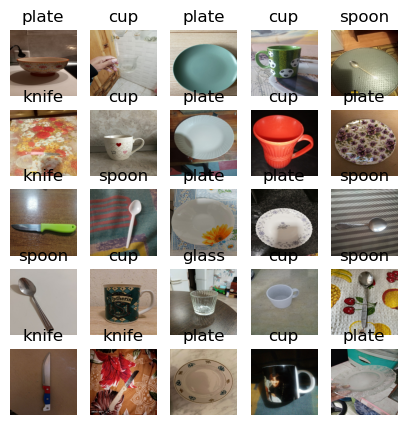

In [7]:
dataset_iterator = dataset.as_numpy_iterator()

plt.figure(figsize=(5, 5))
class_names = dataset.class_names

for i in range(25):
    image, label = next(dataset_iterator)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")


### Ensure RGB values valid

In [8]:
dataset_iterator = dataset.as_numpy_iterator()

rgb_min = None
rgb_max = None

for img, lbl in dataset_iterator:
    flat = img.flatten()

    flat_min = np.min(flat)
    flat_max = np.max(flat)

    if not rgb_min:
        rgb_min = flat_min
    else:
        rgb_min = np.min([flat_min, rgb_min])

    if not rgb_max:
        rgb_max = flat_max
    else:
        rgb_max = np.max([flat_max, rgb_max])

        
print([rgb_min, rgb_max])

[0.15704346, 255.0]


## Keras Tutorial Model

In [36]:
# https://keras.io/examples/vision/image_classification_from_scratch/
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5559 files belonging to 6 classes.
Using 4448 files for training.
Found 5559 files belonging to 6 classes.
Using 1111 files for validation.


In [83]:
# following along with keras tutorial
# https://www.tensorflow.org/tutorials/images/classification

img_height = img_size[0]
img_width = img_size[1]
num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    
    layers.CenterCrop(height=img_height, width=img_width),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(128, activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    
    layers.Dense(num_classes, activation="softmax")
])

In [92]:
# processed_data = model.predict(dataset)
# print(processed_data.shape)

# print(model.summary())

In [51]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [54]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

In [108]:
def get_val_accuracy_delta(history):
    val_accuracy_start = history.history['val_accuracy'][0]
    val_accuracy_end = history.history['val_accuracy'][-1]
    
    return (val_accuracy_end - val_accuracy_start)

model_val_delta = get_val_accuracy_delta(history)

print(f'Change in validation accuracy: {model_val_delta:.3f}')

Change in validation accuracy: 0.000


Not a great model

### Transfer learning with Xception

In [110]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False # Do not include the ImageNet classifier at the top.
)

base_model.trainable = False

In [112]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes)(x)
model_x = keras.Model(inputs, outputs)

In [113]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model_x.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_x = model_x.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
139/139 [==============================] - 33s 206ms/step - loss: 4.7304 - accuracy: 0.3321 - val_loss: 2.6166 - val_accuracy: 0.3843
Epoch 2/10
139/139 [==============================] - 28s 199ms/step - loss: 2.2744 - accuracy: 0.4143 - val_loss: 2.3131 - val_accuracy: 0.3915
Epoch 3/10
139/139 [==============================] - 29s 204ms/step - loss: 2.2580 - accuracy: 0.4357 - val_loss: 2.5456 - val_accuracy: 0.4491
Epoch 4/10
139/139 [==============================] - 29s 207ms/step - loss: 2.3138 - accuracy: 0.4744 - val_loss: 2.6236 - val_accuracy: 0.4527
Epoch 5/10
139/139 [==============================] - 29s 209ms/step - loss: 1.8468 - accuracy: 0.4982 - val_loss: 2.1967 - val_accuracy: 0.4617
Epoch 6/10
139/139 [==============================] - 30s 210ms/step - loss: 2.2405 - accuracy: 0.5002 - val_loss: 3.3035 - val_accuracy: 0.4176
Epoch 7/10
139/139 [==============================] - 29s 208ms/step - loss: 1.8692 - accuracy: 0.5290 - val_loss: 1.8526 - val_ac

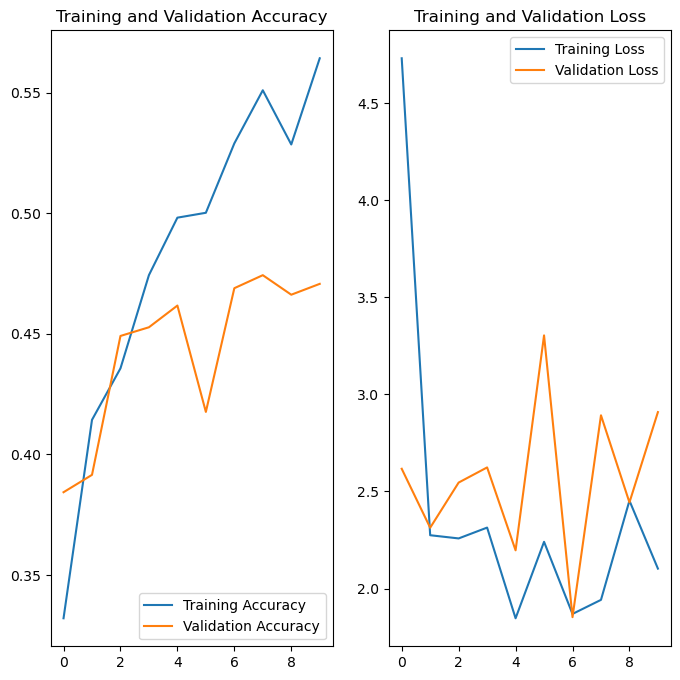

In [114]:
acc = history_x.history['accuracy']
val_acc = history_x.history['val_accuracy']

loss = history_x.history['loss']
val_loss = history_x.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()